<a href="https://colab.research.google.com/github/Yuxingraceguo/Pyspark/blob/main/Wine_Pricing%26Rating_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Rating Analytics

Import libraries and Spark

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [ ]:
!sudo apt-get update
!apt install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,414 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import  *
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import IntegerType


In [ ]:
spark = SparkSession\
        .builder\
        .getOrCreate()

## Import dataset

Note to user: upload dataset onto Google Colab instance.

In [ ]:
#To upload 2015-summary.csv
from google.colab import files
files.upload()

Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


In [ ]:
data = spark.read.option("inferSchema", "true").options(mode='FAILFAST', multiLine=True, escape='"').csv('winemag-data-130k-v2.csv', sep = ',',header = True, inferSchema=True)

In [ ]:
data.show()

+---+---------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+
|_c0|  country|         description|         designation|points|price|         province|           region_1|         region_2|       taster_name|taster_twitter_handle|               title|           variety|             winery|
+---+---------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+
|  0|    Italy|Aromas include tr...|        Vulkà Bianco|    87| null|Sicily & Sardinia|               Etna|             null|     Kerin O’Keefe|         @kerinokeefe|Nicosia 2013 Vulk...|       White Blend|            Nicosia|
|  1| Portugal|This is ripe and ...|            Avidagos|    87| 15.0|            Douro|

## Data Cleaning

Check for missing values.

In [ ]:
from pyspark.sql.functions import count
def my_count(df):
  df.agg(*[count(c).alias(c) for c in df.columns]).show()
my_count(data)
# country cutm, 

+------+-------+-----------+-----------+------+------+--------+--------+--------+-----------+---------------------+------+-------+------+
|   _c0|country|description|designation|points| price|province|region_1|region_2|taster_name|taster_twitter_handle| title|variety|winery|
+------+-------+-----------+-----------+------+------+--------+--------+--------+-----------+---------------------+------+-------+------+
|129971| 129908|     129971|      92506|129971|120975|  129908|  108724|   50511|     103727|                98758|129971| 129970|129971|
+------+-------+-----------+-----------+------+------+--------+--------+--------+-----------+---------------------+------+-------+------+



Let's eliminate the rows with missing prices, as ratings and price are both crucial to our analysis.

In [ ]:
data_cleaned = data.filter(data.price.isNotNull())

Remove records with incorrect data (data does not align with expected type)



In [ ]:
data_cleaned.dtypes

[('_c0', 'int'),
 ('country', 'string'),
 ('description', 'string'),
 ('designation', 'string'),
 ('points', 'int'),
 ('price', 'double'),
 ('province', 'string'),
 ('region_1', 'string'),
 ('region_2', 'string'),
 ('taster_name', 'string'),
 ('taster_twitter_handle', 'string'),
 ('title', 'string'),
 ('variety', 'string'),
 ('winery', 'string')]

Summarize data columns.

In [ ]:
data_cleaned.describe().show()

+-------+-----------------+---------+--------------------+--------------------+-----------------+------------------+--------+------------+-----------------+------------------+---------------------+--------------------+--------+--------+
|summary|              _c0|  country|         description|         designation|           points|             price|province|    region_1|         region_2|       taster_name|taster_twitter_handle|               title| variety|  winery|
+-------+-----------------+---------+--------------------+--------------------+-----------------+------------------+--------+------------+-----------------+------------------+---------------------+--------------------+--------+--------+
|  count|           120975|   120916|              120975|               86196|           120975|            120975|  120916|      101400|            50292|             96479|                91559|              120975|  120974|  120975|
|   mean|65045.76062822897|     null|               

## Exploratory Data Analysis

### Points and Price

Let's plot the ratings.

88.42188055383343

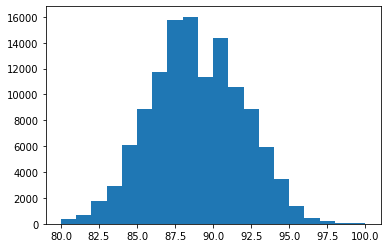

In [ ]:
data_df = data_cleaned.toPandas()
plt.hist(data_df['points'], bins=20)
data_df['points'].mean()

Ratings are fairly normal in their distribution.

What about price?

35.363389129985535

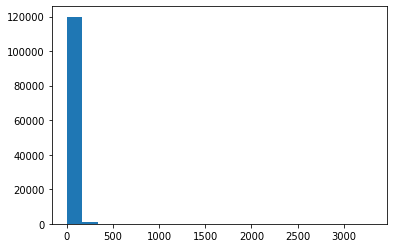

In [ ]:
plt.hist(data_df['price'], bins=20)
data_df['price'].mean()

Control the range of the x-axis.

35.363389129985535

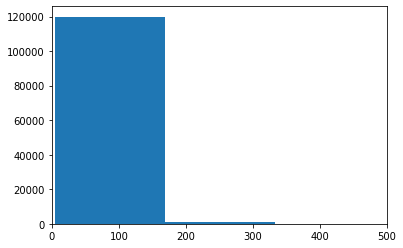

In [ ]:
plt.xlim(0,500)
plt.hist(data_df['price'], bins=20)
data_df['price'].mean()

Not very normal at all. It may be better to take the log of this variable for analysis.

In [ ]:
data_df['log_price'] = np.log(data_df['price'])

# Add it to the Pyspark dataframe too!
data_cleaned = data_cleaned.withColumn('log_price', log(data_cleaned.price))

3.314635885906895

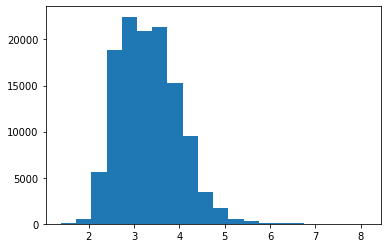

In [ ]:
plt.hist(data_df['log_price'], bins=20)
data_df['log_price'].mean()

Much better. Our price distribution is now fairly normal. From the looks of it, the range of price is quite large, with a mean of $35.

### Varietals

What are the most common varietals?

In [ ]:
topten = data_cleaned.groupby(['variety']).count().alias('count').orderBy('count',ascending = False).limit(10)
topten.show()

+--------------------+-----+
|             variety|count|
+--------------------+-----+
|          Pinot Noir|12787|
|          Chardonnay|11080|
|  Cabernet Sauvignon| 9386|
|           Red Blend| 8476|
|Bordeaux-style Re...| 5340|
|            Riesling| 4972|
|     Sauvignon Blanc| 4783|
|               Syrah| 4086|
|                Rosé| 3262|
|              Merlot| 3062|
+--------------------+-----+



How many varietals are in our dataset?

In [ ]:
data_cleandf = data_cleaned.toPandas()
len(data_cleandf['variety'].unique())

698

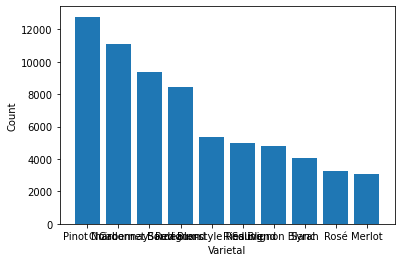

<Figure size 144x144 with 0 Axes>

In [ ]:
toptendf = topten.toPandas()
plt.bar('variety','count',data = toptendf)
plt.xlabel('Varietal')
plt.ylabel('Count')
plt.figure(figsize=(2,2))
plt.show()

What are the most expensive varietals?

In [ ]:
avg_price = data_cleaned.groupby(['variety'])\
.agg(F.avg('price').alias('avg_price'))\
.orderBy('avg_price',ascending = False)

avg_price.show(10)

+----------------+------------------+
|         variety|         avg_price|
+----------------+------------------+
|         Ramisco|             495.0|
|       Terrantez|             236.0|
|        Francisa|             160.0|
|Rosenmuskateller|             150.0|
| Malbec-Cabernet|113.33333333333333|
|Tinta Negra Mole|             112.0|
|      Muscadelle|             111.2|
|            Bual|             100.0|
|           Debit| 98.33333333333333|
| Cabernet-Shiraz|              83.5|
+----------------+------------------+
only showing top 10 rows



The most expensive varietals are not in our top 10 most common varietals. This could be due to the rarity of the varietals in our dataset.

What are the highest rated varietals?

In [ ]:
avg_rating = data_cleaned.groupby(['variety'])\
.agg(F.avg('points').alias('avg_points'))\
.orderBy('avg_points',ascending = False)

avg_rating.show(10)

+-------------------+-----------------+
|            variety|       avg_points|
+-------------------+-----------------+
|          Terrantez|             95.0|
|     Tinta del Pais|             95.0|
|    Gelber Traminer|             95.0|
|               Bual|94.33333333333333|
|Riesling-Chardonnay|             94.0|
|            Sercial|             94.0|
|      Blauburgunder|             93.0|
|  Garnacha-Cariñena|             93.0|
|           Roviello|             93.0|
|            Ramisco|             93.0|
+-------------------+-----------------+
only showing top 10 rows



### Rating and price correlation

What is the relationship between rating and price?

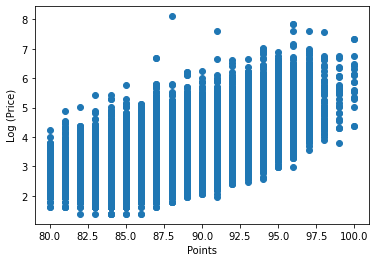

In [ ]:
points = data_df['points']
logprice = data_df['log_price']

plt.scatter(points, logprice)
plt.xlabel('Points')
plt.ylabel('Log (Price)')
plt.show()

There does appear to be a positive linear relationship between price and rating.
What is the exact Pearson's correlation coefficient?

In [ ]:
my_rho = np.corrcoef(points, logprice)
my_rho

array([[1.       , 0.6118495],
       [0.6118495, 1.       ]])

The correlation between price and rating is moderately positive.

### Grape type

Next, are white or red wines higher priced and higher rated? To explore this we'll need to create a "red/white" feature.

In [ ]:
# Create string vectors of varietals in our Top 10 set.
red = ['Pinot Noir','Cabernet Sauvignon','Red Blend','Bordeaux-style Red Blend','Syrah','Merlot']
white = ['Chardonnay','Riesling','Sauvignon Blanc']
rose = ['Rosé']
toptenvar = red+white+rose

In [ ]:
toptenvar

['Pinot Noir',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Syrah',
 'Merlot',
 'Chardonnay',
 'Riesling',
 'Sauvignon Blanc',
 'Rosé']

In [ ]:
# Subset by top 10 only
data_topten = data_cleaned.where(col('variety').isin(toptenvar))

In [ ]:
# Next create a "grape" column
data_topten = data_topten.withColumn('grape',when(col('variety').isin(red),'red').otherwise(when(col('variety').isin(white),'white').otherwise('rosé')))
data_topten.show(10)

+---+-------+--------------------+--------------------+------+-----+----------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+-----+
|_c0|country|         description|         designation|points|price|  province|           region_1|         region_2|       taster_name|taster_twitter_handle|               title|           variety|             winery|         log_price|grape|
+---+-------+--------------------+--------------------+------+-----+----------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+-----+
|  3|     US|Pineapple rind, l...|Reserve Late Harvest|    87| 13.0|  Michigan|Lake Michigan Shore|             null|Alexander Peartree|                 null|St. Julian 2013 R...|          Riesling|         St. Julian|2.5649493574615367|white|
|  4|     US|Much like t

In [ ]:
test = data_topten.groupby(['grape']).count().alias('count').orderBy('count',ascending = False).limit(10)
test.show()

+-----+-----+
|grape|count|
+-----+-----+
|  red|43137|
|white|20835|
| rosé| 3262|
+-----+-----+



In [ ]:
data_toptendf = data_topten.toPandas()
len(data_toptendf[data_toptendf['grape']=='red'])

43137

In [ ]:
len(data_toptendf[data_toptendf['grape']=='white'])

20835

What's the mean price and rating for red and white wines?

In [ ]:
avgs_grape = data_topten.groupby(['grape'])\
.agg(F.avg('points').alias('avg_points'), F.avg('price').alias('avg_price'))
avgs_grape.show()

+-----+-----------------+------------------+
|grape|       avg_points|         avg_price|
+-----+-----------------+------------------+
|white|88.36837053035757|30.638972882169426|
|  red|88.78871966061618|43.218837656767974|
| rosé| 86.8856529736358|18.506437768240342|
+-----+-----------------+------------------+



While the average points for red and white varietals are about the same, the average price of red wines is \$13 more expensive than the average for white wines and \$25 more expensive than the average for rosés.

### Year

Does year have any bearing on rating or price?

In [ ]:
# Create a new column 'year' by extracting the year from the title column of each row. Note that this refers to the 
# vintage of the wine, not the year of the review.

rexpr = '(\d{4})'

data_topten = data_topten.withColumn('year', regexp_extract(data_topten.title, rexpr, 1))\
.withColumn('year',col('year').cast(IntegerType())) # cast as integer

Now I want to clean the dataset so that we only have reasonable vintage years and no missing values in that column. "Unreasonable" vintages may be a result of some wine titles containing multiple years, one as the title flair and one as the actual year.

In [ ]:
data_topten = data_topten.filter(col('year') >= 1997)\
.filter(col('year') <= 2021)

In [ ]:
data_topten.agg(max(col("year"))).show()

+---------+
|max(year)|
+---------+
|     2017|
+---------+



2010.8056899175745

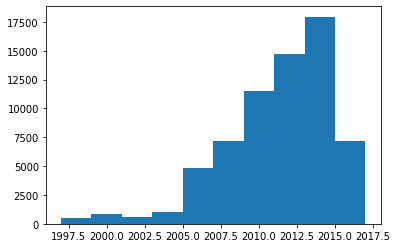

In [ ]:
tempdf = data_topten.toPandas()

plt.hist(tempdf['year'])
tempdf['year'].mean()

Is there a correlation between year and rating? Year and price?

In [ ]:
# Reassign data_df, points, price, and assign year
data_df = data_topten.toPandas()

points = data_df['points']
logprice = data_df['log_price']
year = data_df['year']

rho_points_year = np.corrcoef(points,year)
rho_logprice_year = np.corrcoef(logprice,year)

rho_points_year

array([[1.        , 0.09540301],
       [0.09540301, 1.        ]])

In [ ]:
rho_logprice_year

array([[ 1.        , -0.05118222],
       [-0.05118222,  1.        ]])

There appears to be **none or weak** correlation between a bottle's vintage year and the rating or price it would fetch. Still, it would be interesting to see the relationships visually.

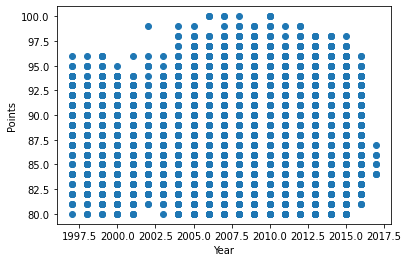

In [ ]:
plt.scatter(year,points)
plt.xlabel('Year')
plt.ylabel('Points')
plt.show()

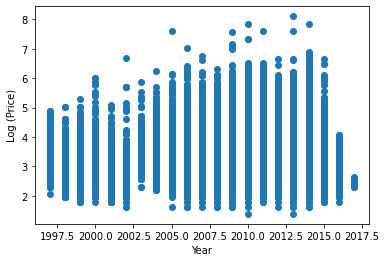

In [ ]:
plt.scatter(year,logprice)
plt.xlabel('Year')
plt.ylabel('Log (Price)')
plt.show()

No visual evidence of a linear relationship either.

### Country and Province

Next, what are the top 10 countries and regions by rating and price? We will use the cleaned dataset, not just the one containing the 10 most rated varietals.

In [ ]:
countries_count = data_cleaned.groupby(['country'])\
.count()\
.orderBy('count', ascending = False)\
.limit(10)

countries_count.show(10, False)

+---------+-----+
|country  |count|
+---------+-----+
|US       |54265|
|France   |17776|
|Italy    |16914|
|Spain    |6573 |
|Portugal |4875 |
|Chile    |4416 |
|Argentina|3756 |
|Austria  |2799 |
|Australia|2294 |
|Germany  |2120 |
+---------+-----+



In [ ]:
data_cleaned.show()

+---+---------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+
|_c0|  country|         description|         designation|points|price|         province|           region_1|         region_2|       taster_name|taster_twitter_handle|               title|           variety|             winery|         log_price|
+---+---------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+
|  1| Portugal|This is ripe and ...|            Avidagos|    87| 15.0|            Douro|               null|             null|        Roger Voss|           @vossroger|Quinta dos Avidag...|    Portuguese Red|Quinta dos Avidagos|  2.70805020110221|
|  2|       

In [ ]:
top4 = ['US','France','Italy','Spain']

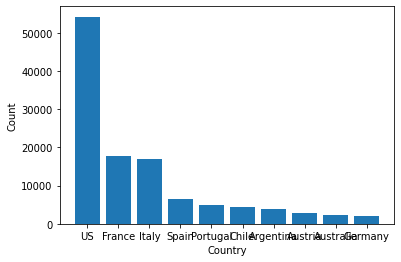

In [ ]:
countries_countdf = countries_count.toPandas()
plt.bar('country','count',data = countries_countdf)
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

Wines in the dataset are about 3 or more times as likely to be from the United States than from any other country.

In [ ]:
countries_topten = data_cleaned.groupby(['country'])\
.agg(F.avg('price').alias('avg_price'))\
.orderBy(col('avg_price'), ascending = False)\
.limit(10)

countries_topten.show()

+-----------+------------------+
|    country|         avg_price|
+-----------+------------------+
|Switzerland| 85.28571428571429|
|    England| 51.68115942028985|
|    Germany| 42.25754716981132|
|     France|41.139120162016205|
|    Hungary|40.648275862068964|
|      Italy|39.663769658271256|
|         US|  36.5734635584631|
|     Canada| 35.71259842519685|
|  Australia| 35.43766346992153|
|     Israel|31.768916155419223|
+-----------+------------------+



In [ ]:
countries_toppts = data_cleaned.groupby(['country'])\
.agg(F.avg('points').alias('avg_points'))\
.orderBy(col('avg_points'), ascending = False)\
.limit(10)

countries_toppts.show()

+----------+-----------------+
|   country|       avg_points|
+----------+-----------------+
|   England|91.55072463768116|
|     India|90.22222222222223|
|   Austria|90.19078242229368|
|   Germany|89.83632075471698|
|    Canada|89.37795275590551|
|   Hungary| 89.1655172413793|
|     China|             89.0|
|      null| 88.7457627118644|
|    France|88.73486723672367|
|Luxembourg|88.66666666666667|
+----------+-----------------+



In [ ]:
province_topten = data_cleaned.groupby(['province','country'])\
.agg(F.avg('price').alias('avg_price'))\
.orderBy(col('avg_price'), ascending = False)\
.limit(10)

province_topten.show()

+-----------------+-----------+------------------+
|         province|    country|         avg_price|
+-----------------+-----------+------------------+
|          Colares|   Portugal|             262.5|
|       Vânju Mare|    Romania|             166.0|
|      Switzerland|Switzerland|             160.0|
|          Madeira|   Portugal|115.18181818181819|
|Moscatel do Douro|   Portugal|             103.2|
|      Puente Alto|      Chile|              84.5|
|             Buin|      Chile|            83.625|
|         Rheingau|    Germany|  79.8538961038961|
|        Champagne|     France| 79.46131597975416|
|       Santa Cruz|      Chile|              77.5|
+-----------------+-----------+------------------+



In [ ]:
province_toppts = data_cleaned.groupby(['province','country'])\
.agg(F.avg('points').alias('avg_points'))\
.orderBy(col('avg_points'), ascending = False)\
.limit(10)

province_toppts.show()

+-------------+--------+-----------------+
|     province| country|       avg_points|
+-------------+--------+-----------------+
|Südburgenland| Austria|             94.0|
|      Madeira|Portugal| 93.9090909090909|
|  Mittelrhein| Germany|            92.25|
|  Puente Alto|   Chile|91.85714285714286|
|       Wachau| Austria|91.66558441558442|
|      England| England|91.55072463768116|
|   Santa Cruz|   Chile|             91.5|
|   Leithaberg| Austria|91.44117647058823|
|      Kamptal| Austria|91.39644970414201|
|   Traisental| Austria|91.25581395348837|
+-------------+--------+-----------------+



Top 4 most rated wines only

In [ ]:
countries_top4 = data_cleaned.groupby(['country'])\
.agg(F.avg('points').alias('avg_points'))\
.where(col('country').isin(top4))

countries_top4.show()

+-------+-----------------+
|country|       avg_points|
+-------+-----------------+
| France|88.73486723672367|
|  Italy|88.61818611800875|
|  Spain|87.29073482428115|
|     US|88.56638717405326|
+-------+-----------------+



In [ ]:
countries_top4 = data_cleaned.groupby(['country'])\
.agg(F.avg('price').alias('avg_price'))\
.where(col('country').isin(top4))

countries_top4.show()

+-------+------------------+
|country|         avg_price|
+-------+------------------+
| France|41.139120162016205|
|  Italy|39.663769658271256|
|  Spain|28.215274608245853|
|     US|  36.5734635584631|
+-------+------------------+



### Winery

What are the most expensive and top rated wineries?

In [ ]:
winery_topten = data_cleaned.groupby(['winery','country'])\
.agg(F.avg('price').alias('avg_price'))\
.orderBy(col('avg_price'), ascending = False)\
.limit(10)

winery_topten.show()

+--------------------+-------+-----------------+
|              winery|country|        avg_price|
+--------------------+-------+-----------------+
|Château les Ormes...| France|           3300.0|
|      Château Pétrus| France|           2250.0|
|Domaine du Comte ...| France|          1488.75|
|Château Cheval Blanc| France|            825.0|
|     Château d'Yquem| France|            800.0|
|             Masseto|  Italy|            587.5|
|Château Laville H...| France|            580.0|
|  Château Haut-Brion| France|            571.7|
|Château La Missio...| France|           545.75|
|      Château Ausone| France|506.6666666666667|
+--------------------+-------+-----------------+



France has got some gucci wines!

In [ ]:
winery_toppts = data_cleaned.groupby(['winery','country'])\
.agg(F.avg('points').alias('avg_points'))\
.orderBy(col('avg_points'), ascending = False)\
.limit(10)

winery_toppts.show()

+--------------------+---------+----------+
|              winery|  country|avg_points|
+--------------------+---------+----------+
|              Araujo|       US|      98.0|
|        Clos de Tart|   France|      98.0|
|             Gandona|       US|      97.0|
|                Ovid|       US|      97.0|
|            Standish|Australia|      97.0|
|     Château Angélus|   France|      97.0|
|     Château d'Yquem|   France|      97.0|
|          J.L. Chave|   France|      97.0|
|Château Cheval Blanc|   France|      97.0|
|               Salon|   France|      96.8|
+--------------------+---------+----------+



## Text Analysis

In [ ]:
 data_cleaned.columns

['_c0',
 'country',
 'description',
 'designation',
 'points',
 'price',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'taster_twitter_handle',
 'title',
 'variety',
 'winery',
 'log_price']

In [ ]:
## Data Cleaning: 
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import ArrayType, StringType


# Clean text
df_clean = data_cleaned.select('_c0', (lower(regexp_replace('description', "[^a-zA-Z\\s]", "")).alias('description')))

# Tokenize text
tokenizer = Tokenizer(inputCol='description', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('_c0', 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('_c0', 'words_clean')

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens],ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('_c0', 'words_stemmed')


# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

# Load documents
documents = df_final_words.select('words','_c0')

In [ ]:
# TF-IDF Document Matrix
from __future__ import print_function
 
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql import SparkSession
 
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)

featurizedData = hashingTF.transform(documents)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
 
rescaledData.select('_c0', "features").show()


+---+--------------------+
|_c0|            features|
+---+--------------------+
|  1|(20,[0,1,3,7,8,9,...|
|  2|(20,[6,9,11,13,14...|
|  3|(20,[1,3,5,7,8,9,...|
|  4|(20,[0,4,5,6,7,8,...|
|  5|(20,[1,2,4,6,7,10...|
|  6|(20,[1,2,3,4,5,7,...|
|  7|(20,[2,4,6,7,10,1...|
|  8|(20,[1,4,5,8,9,10...|
|  9|(20,[6,9,10,12,13...|
| 10|(20,[8,9,10,11,12...|
| 11|(20,[0,3,6,9,13,1...|
| 12|(20,[0,1,2,4,7,8,...|
| 14|(20,[0,1,3,6,8,9,...|
| 15|(20,[2,3,7,8,9,12...|
| 16|(20,[0,1,2,3,4,5,...|
| 17|(20,[0,1,2,6,8,13...|
| 18|(20,[1,4,5,6,7,8,...|
| 19|(20,[1,2,3,4,5,6,...|
| 20|(20,[0,1,4,6,7,8,...|
| 21|(20,[0,1,2,4,6,7,...|
+---+--------------------+
only showing top 20 rows



In [ ]:
df_text=rescaledData.select('_c0', "features")

## Predict Price

In [ ]:
# Results from text analysis
df_text.show()

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  1|(20,[0,1,3,7,8,9,...|
|  2|(20,[6,9,11,13,14...|
|  3|(20,[1,3,5,7,8,9,...|
|  4|(20,[0,4,5,6,7,8,...|
|  5|(20,[1,2,4,6,7,10...|
|  6|(20,[1,2,3,4,5,7,...|
|  7|(20,[2,4,6,7,10,1...|
|  8|(20,[1,4,5,8,9,10...|
|  9|(20,[6,9,10,12,13...|
| 10|(20,[8,9,10,11,12...|
| 11|(20,[0,3,6,9,13,1...|
| 12|(20,[0,1,2,4,7,8,...|
| 14|(20,[0,1,3,6,8,9,...|
| 15|(20,[2,3,7,8,9,12...|
| 16|(20,[0,1,2,3,4,5,...|
| 17|(20,[0,1,2,6,8,13...|
| 18|(20,[1,4,5,6,7,8,...|
| 19|(20,[1,2,3,4,5,6,...|
| 20|(20,[0,1,4,6,7,8,...|
| 21|(20,[0,1,2,4,6,7,...|
+---+--------------------+
only showing top 20 rows



In [ ]:
data_cleaned.show()

+---+---------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+
|_c0|  country|         description|         designation|points|price|         province|           region_1|         region_2|       taster_name|taster_twitter_handle|               title|           variety|             winery|         log_price|
+---+---------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+
|  1| Portugal|This is ripe and ...|            Avidagos|    87| 15.0|            Douro|               null|             null|        Roger Voss|           @vossroger|Quinta dos Avidag...|    Portuguese Red|Quinta dos Avidagos|  2.70805020110221|
|  2|       

In [ ]:
data_cleaned.columns

['_c0',
 'country',
 'description',
 'designation',
 'points',
 'price',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'taster_twitter_handle',
 'title',
 'variety',
 'winery',
 'log_price']

In [ ]:
# Extract year from title column and remove abnormal values
rexpr = '(\d{4})'
dff=data_cleaned.withColumn('year', regexp_extract(data_cleaned.title, rexpr, 1))\
.withColumn('year',col('year').cast(IntegerType())) # cast as integer

dff= dff.filter(col('year') >= 1970)\
.filter(col('year') <= 2021)

In [ ]:
# dff=data_cleaned

In [ ]:
# Features selected into the model: 
# country, TFIDF, province, variety, winery, grape
# Create grape column:
dff = dff.withColumn('grape',when(col('variety').isin(red),'red').otherwise(when(col('variety').isin(white),'white').otherwise(when(col('variety').isin(rose),'rose').otherwise('other'))))
dff.show(10)


+---+--------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+----+-----+
|_c0| country|         description|         designation|points|price|         province|           region_1|         region_2|       taster_name|taster_twitter_handle|               title|           variety|             winery|         log_price|year|grape|
+---+--------+--------------------+--------------------+------+-----+-----------------+-------------------+-----------------+------------------+---------------------+--------------------+------------------+-------------------+------------------+----+-----+
|  1|Portugal|This is ripe and ...|            Avidagos|    87| 15.0|            Douro|               null|             null|        Roger Voss|           @vossroger|Quinta dos Avidag...|    Portuguese Red|Quinta dos Avidagos|  2

In [ ]:
# top 10 rating wineries
# topten_winery=[row.winery for row in winery_toppts.collect()]
# top 10 expensive wineries
topten_winery=[row.winery for row in winery_topten.collect()]

In [ ]:
topten_winery

['Château les Ormes Sorbet',
 'Château Pétrus',
 'Domaine du Comte Liger-Belair',
 'Château Cheval Blanc',
 "Château d'Yquem",
 'Masseto',
 'Château Laville Haut-Brion',
 'Château Haut-Brion',
 'Château La Mission Haut-Brion',
 'Château Ausone']

In [ ]:

# Convert categorical variables to dummies
import pyspark.sql.functions as F

country = dff.select('country').distinct().rdd.flatMap(lambda x: x).collect()
country_n=[x for x in country if x is not None]

province = dff.select('province').distinct().rdd.flatMap(lambda x: x).collect()
province_n=[x for x in province if x is not None]


grape= dff.select('grape').distinct().rdd.flatMap(lambda x: x).collect()
grape_n=[x for x in grape if x is not None]

# designation = dff.select('designation').distinct().rdd.flatMap(lambda x: x).collect()
# designation_n=[x for x in country if x is not None]

variety_expr= [F.when(F.col('variety') == vt, 1).otherwise(0).alias("e_variety_" + vt) for vt in toptenvar]
winery_expr= [F.when(F.col('winery') == wy, 1).otherwise(0).alias("e_winery_" + wy) for wy in topten_winery]
country_expr = [F.when(F.col('country') == ct, 1).otherwise(0).alias("e_country_" + ct) for ct in country_n]
province_expr= [F.when(F.col('province') == pr, 1).otherwise(0).alias("e_province_" + pr) for pr in province_n]
grape_expr= [F.when(F.col('grape') == gr, 1).otherwise(0).alias("e_grape_" + gr) for gr in grape_n]
# designation_expr = [F.when(F.col('designation') == de, 1).otherwise(0).alias("e_designation_" + de) for de in designation_n]


In [ ]:
df = dff.select('_c0','log_price','points','year', *variety_expr+winery_expr+country_expr+province_expr+grape_expr)
df.show()

+---+------------------+------+----+--------------------+----------------------------+-------------------+----------------------------------+---------------+----------------+--------------------+------------------+-------------------------+--------------+---------------------------------+-----------------------+--------------------------------------+-----------------------------+------------------------+----------------+-----------------------------------+---------------------------+--------------------------------------+-----------------------+----------------+-----------------+----------------+----------------+------------------+-------------------+--------------+---------------+---------------+---------------+-----------------+---------------+---------------+------------+-----------------+-----------------+----------------+----------------+-----------------+----------------+-----------------+-----------------+---------------------+----------------+-------------------+---------------

In [ ]:
# Merge datasets to have the full data for ML analysis
df_all=df.join(df_text, on=['_c0'], how='inner')
df_all.show()

+---+------------------+------+----+--------------------+----------------------------+-------------------+----------------------------------+---------------+----------------+--------------------+------------------+-------------------------+--------------+---------------------------------+-----------------------+--------------------------------------+-----------------------------+------------------------+----------------+-----------------------------------+---------------------------+--------------------------------------+-----------------------+----------------+-----------------+----------------+----------------+------------------+-------------------+--------------+---------------+---------------+---------------+-----------------+---------------+---------------+------------+-----------------+-----------------+----------------+----------------+-----------------+----------------+-----------------+-----------------+---------------------+----------------+-------------------+---------------

In [ ]:
# Change the name, otherwise an error will raise
# df_all = df_all.withColumnRenamed("e_winery_J.L. Chave", "e_winery_JL_Chave")

In [ ]:
## Prepare data for regression
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = df_all.drop('log_price','_c0').columns, outputCol = 'X vars')
vhouse_df = vectorAssembler.transform(df_all)
vhouse_df.show(3)

+---+------------------+------+----+--------------------+----------------------------+-------------------+----------------------------------+---------------+----------------+--------------------+------------------+-------------------------+--------------+---------------------------------+-----------------------+--------------------------------------+-----------------------------+------------------------+----------------+-----------------------------------+---------------------------+--------------------------------------+-----------------------+----------------+-----------------+----------------+----------------+------------------+-------------------+--------------+---------------+---------------+---------------+-----------------+---------------+---------------+------------+-----------------+-----------------+----------------+----------------+-----------------+----------------+-----------------+-----------------+---------------------+----------------+-------------------+---------------

In [ ]:
## Random Forest Regressor 
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol='log_price', featuresCol="X vars")
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, rf])

In [ ]:
# Train Test Split and train the model
(trainingData, testData) = df_all.randomSplit([0.7, 0.3])
model = pipeline.fit(trainingData)

In [ ]:
# Prediction
predictions = model.transform(testData)

In [ ]:
# Evaluate Model performance using RMSE
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol='log_price', predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:
# Evaluate Model performance using RMSE, MAE,MSE and R Squared
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
mse= evaluator.setMetricName("mse").evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)
mae= evaluator.setMetricName("mae").evaluate(predictions)
print("RMSE: {}\nMAE:{}\nMSE:{}\nR2: {}".format(rmse,mae,mse,r2))

RMSE: 0.4750997657823836
MAE:0.37040725295218896
MSE:0.22571978744647578
R2: 0.47041177260840117


In [ ]:
predictions.select("prediction").show(5)

+------------------+
|        prediction|
+------------------+
| 3.335202889121631|
| 2.984496469311261|
|3.0858583480973474|
|3.4403529792571717|
| 2.977363640060892|
+------------------+
only showing top 5 rows



In [ ]:
# Evaluate Model performance using R Squared
# import sklearn.metrics
# r2_score = sklearn.metrics.r2_score(np.array(testData.select('log_price').collect()), np.array(predictions.select('prediction').collect()))
# print('r2_score: {:4.3f}'.format(r2_score))

In [ ]:
# Print feature importance
va = model.stages[-2]
tree = model.stages[-1]

display(tree) #visualize the decision tree model
# print(tree.toDebugString) #print the nodes of the decision tree model

list(zip(va.getInputCols(), tree.featureImportances))[-20:]

RandomForestRegressionModel: uid=RandomForestRegressor_83ce472350d9, numTrees=20, numFeatures=503

[('e_province_Elazığ', 0.0),
 ('e_province_Ticino', 0.0),
 ('e_province_Kakheti', 0.0),
 ('e_province_Moldova', 0.0),
 ('e_province_Portuguese Table Wine', 0.0),
 ('e_province_East Coast', 0.0),
 ('e_province_Cyclades', 0.0),
 ('e_province_Colorado', 0.0),
 ('e_province_Casablanca-Curicó Valley', 0.0),
 ('e_province_Central Greece', 0.0),
 ('e_province_Vale dos Vinhedos', 0.0),
 ('e_province_Durbanville', 0.0),
 ('e_province_Marchigue', 0.0),
 ('e_province_Puente Alto', 0.0),
 ('e_province_Samos', 0.0),
 ('e_grape_other', 0.000939831762299879),
 ('e_grape_white', 0.0021028756732957648),
 ('e_grape_red', 0.07898539859209544),
 ('e_grape_rose', 0.00010836149203890922),
 ('features', 5.312896143303531e-05)]

In [ ]:
 df_feature_imp=pd.DataFrame(tree.featureImportances.toArray())
 df_feature_imp= df_feature_imp.iloc[:len(va.getInputCols())]
 df_feature_imp['x']=va.getInputCols()
 df_feature_imp[0]= df_feature_imp[0].astype(float, errors = 'raise')

In [ ]:
 fi_p=df_feature_imp.sort_values(0,ascending=False)[:10]
 fi_p

,0,x
0,0.671035,points
481,0.078985,e_grape_red
35,0.034651,e_country_US
1,0.031900,year
206,0.029426,e_province_Burgundy
2,0.022283,e_variety_Pinot Noir
437,0.021912,e_province_California
202,0.020463,e_province_Piedmont
31,0.019133,e_country_Chile
83,0.012235,e_province_Champagne


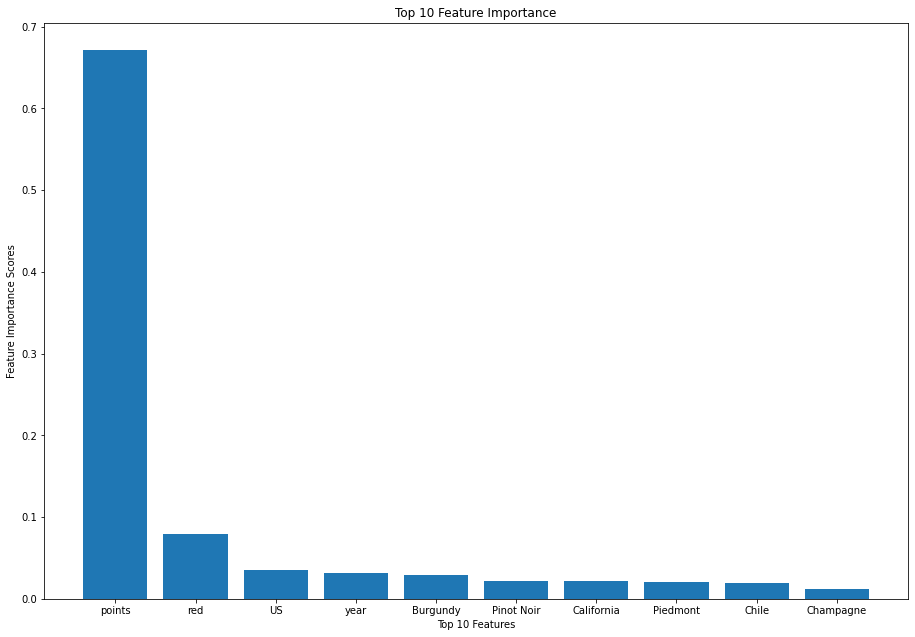

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([1,1,2,2])
features = ['points','red','US','year','Burgundy','Pinot Noir','California','Piedmont','Chile','Champagne']
feature_score = fi_p[0].values
ax.set_ylabel('Feature Importance Scores')
ax.set_title('Top 10 Feature Importance')
ax.set_xlabel('Top 10 Features')
ax.bar(features,feature_score)
plt.show()

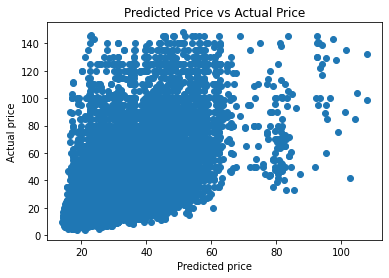

In [ ]:
# Plot Model Performance
no_outlier=predictions[predictions['log_price']<=5]
actual= np.array([np.exp(row.log_price) for row in no_outlier.collect()])
pred = np.array([np.exp(row.prediction) for row in no_outlier.collect()])
plt.scatter(pred ,actual)
plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title("Predicted Price vs Actual Price")
plt.show()

# Predict points using country, TFIDF, province, variety, winery, and grape in case that the points info is not available when predicting the price

In [ ]:
## Prepare data for regression
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = df_all.drop('log_price','_c0','points').columns, outputCol = 'X vars')
vhouse_df = vectorAssembler.transform(df_all)
vhouse_df.show(3)

+---+------------------+------+----+--------------------+----------------------------+-------------------+----------------------------------+---------------+----------------+--------------------+------------------+-------------------------+--------------+---------------------------------+-----------------------+--------------------------------------+-----------------------------+------------------------+----------------+-----------------------------------+---------------------------+--------------------------------------+-----------------------+----------------+-----------------+----------------+----------------+------------------+-------------------+--------------+---------------+---------------+---------------+-----------------+---------------+---------------+------------+-----------------+-----------------+----------------+----------------+-----------------+----------------+-----------------+-----------------+---------------------+----------------+-------------------+---------------

In [ ]:
## Random Forest Regressor 
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol='points', featuresCol="X vars")
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, rf])

In [ ]:
# Train Test Split and train the model
(trainingData, testData) = df_all.randomSplit([0.7, 0.3])
model = pipeline.fit(trainingData)

In [ ]:
# Prediction
predictions = model.transform(testData)

In [ ]:
# Evaluate Model performance using RMSE
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol='points', predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
mse= evaluator.setMetricName("mse").evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)
mae= evaluator.setMetricName("mae").evaluate(predictions)
print("RMSE: {}\nMAE:{}\nMSE:{}\nR2: {}".format(rmse,mae,mse,r2))

RMSE: 2.740453657576324
MAE:2.2170570893113863
MSE:7.510086249323453
R2: 0.1981633174704288


In [ ]:
# feature importance
va = model.stages[-2]
tree = model.stages[-1]
display(tree) #visualize the decision tree model
# print(tree.toDebugString) #print the nodes of the decision tree model
list(zip(va.getInputCols(), tree.featureImportances))[-20:]

RandomForestRegressionModel: uid=RandomForestRegressor_b5f9d322c8df, numTrees=20, numFeatures=502

[('e_province_Elazığ', 0.0),
 ('e_province_Ticino', 0.0),
 ('e_province_Kakheti', 0.0),
 ('e_province_Moldova', 0.0),
 ('e_province_Portuguese Table Wine', 0.0),
 ('e_province_East Coast', 0.0),
 ('e_province_Cyclades', 0.0),
 ('e_province_Colorado', 0.0),
 ('e_province_Casablanca-Curicó Valley', 0.0),
 ('e_province_Central Greece', 0.0),
 ('e_province_Vale dos Vinhedos', 0.0),
 ('e_province_Durbanville', 0.0),
 ('e_province_Marchigue', 0.0),
 ('e_province_Puente Alto', 0.0),
 ('e_province_Samos', 0.0),
 ('e_grape_other', 0.0001746317790257447),
 ('e_grape_white', 0.0),
 ('e_grape_red', 0.0018623450248462254),
 ('e_grape_rose', 0.0),
 ('features', 0.0)]

In [ ]:
df_feature_imp=pd.DataFrame(tree.featureImportances.toArray())
df_feature_imp= df_feature_imp.iloc[:len(va.getInputCols())]
df_feature_imp['x']=va.getInputCols()
df_feature_imp[0]= df_feature_imp[0].astype(float, errors = 'raise')
fi_p=df_feature_imp.sort_values(0,ascending=False)[:10]
fi_p

,0,x
30,0.010290,e_country_Chile
0,0.007989,year
436,0.006824,e_province_California
1,0.005742,e_variety_Pinot Noir
34,0.001953,e_country_US
480,0.001862,e_grape_red
82,0.001520,e_province_Champagne
26,0.001393,e_country_Argentina
8,0.001059,e_variety_Riesling
201,0.000667,e_province_Piedmont


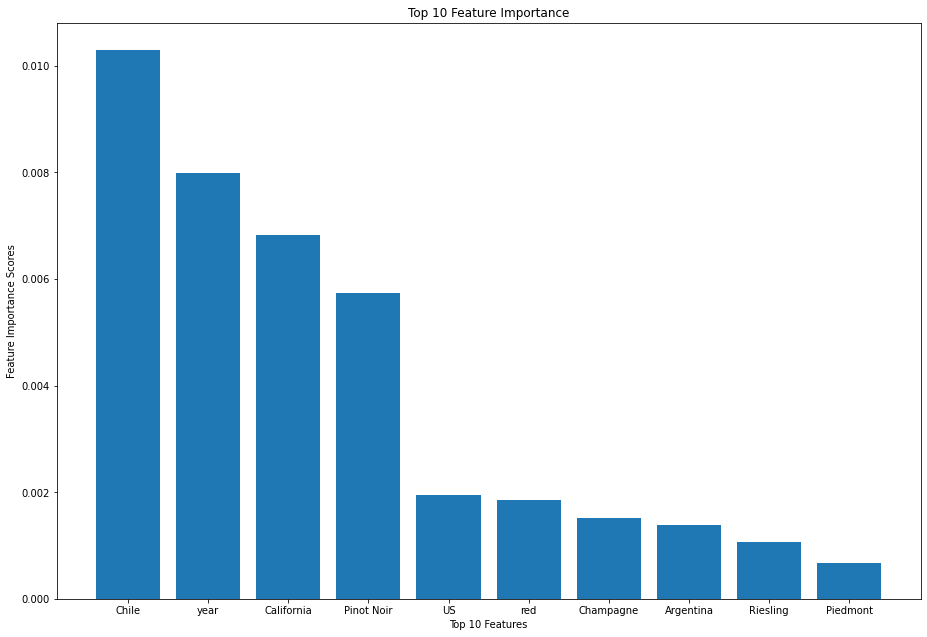

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([1,1,2,2])
features = ['Chile','year','California','Pinot Noir','US','red','Champagne','Argentina','Riesling','Piedmont' ]
feature_score = fi_p[0].values
ax.set_ylabel('Feature Importance Scores')
ax.set_title('Top 10 Feature Importance')
ax.set_xlabel('Top 10 Features')
ax.bar(features,feature_score)
plt.show()

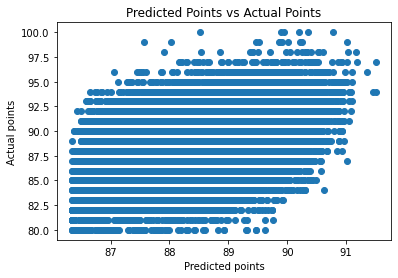

In [ ]:
# Plot Model Performance
actual= np.array(predictions.select('points').collect())
pred = np.array(predictions.select('prediction').collect())
plt.scatter(pred ,actual)
plt.xlabel('Predicted points')
plt.ylabel('Actual points')
plt.title("Predicted Points vs Actual Points")
plt.show()